# Implementing full space-time FEM in FEniCS

In [1]:
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

## Full space-time Finite Element Method
Now that you have understood how the Poisson problem can be solved in FEniCS, you will now need to extend this to a full space-time code. For this you will need to solve the heat equation in one spatial dimension, which is given by
$$
\partial_t u - \partial_{xx} u = f \qquad \forall x \in \Omega := (0,1),\, t \in I := \left(0,\frac{1}{2}\right).
$$
The analytical solution is given by $u(x,t) := \sin(\pi x)(1 + t)\exp(-\frac{t}{2})$.
On all space-time boundaries, we prescribe Dirichlet boundary conditions using the analytical solution and the right hand side $f$ is being derived by plugging the analytical solution into the PDE.

The right hand side is given by
$$
f(x,t) = \sin(\pi x)\exp\left(-\frac{t}{2}\right)\left(\frac{1}{2}+\pi^2+\left(\pi^2-\frac{1}{2}\right)t\right).
$$

The space-time variational formulation is: Find $u \in V$ such that
$$
\int_{\Omega \times I} \partial_t u \varphi + \partial_x u \partial_x \varphi\ \mathrm{d}(x,t) = \int_{\Omega \times I} f\varphi\ \mathrm{d}(x,t) \qquad \forall \varphi \in V.
$$

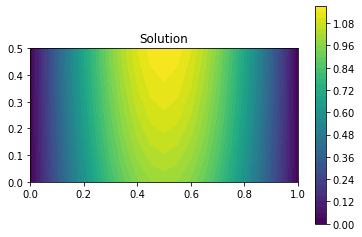

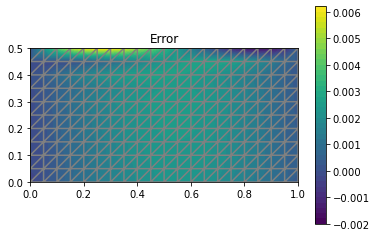

L2 error: 0.001375216698747744


In [2]:
from fenics import *
import matplotlib.pyplot as plt
import math

set_log_active(False) # turn off FEniCS logging

# SOLUTION:
# define space-time mesh
t0 = 0. # start time
T = 0.5 # end time
x_min = 0.
x_max = 1.
n_time = 10
n_space = 20

# coordinates: (x,t)
mesh = RectangleMesh(Point(x_min, t0), Point(x_max, T), n_space, n_time)

V = FunctionSpace(mesh, 'P', 1)

# Analytical solution U is used as Dirichlet BC for x ∈ ∂Ω = {x_min, x_max} or t = t0
U = Expression('sin(pi*x[0])*(1.+x[1])*exp(-0.5*x[1])', degree=2, pi=math.pi)
bc = DirichletBC(V, U, lambda x, on_boundary: (near(x[0], x_min) or near(x[0], x_max) or near(x[1], t0)) and on_boundary)

# Define variational problem
f = Expression('sin(pi*x[0])*exp(-0.5*x[1])*(0.5+pow(pi,2)+(pow(pi,2)-0.5)*x[1])', degree=2, pi=math.pi)
u = TrialFunction(V)
v = TestFunction(V)
a = grad(u)[1]*v*dx + grad(u)[0]*grad(v)[0]*dx
L = f*v*dx

# Solve
u_h = Function(V)
solve(a == L, u_h, bc)

# Plot solution and error
plt.title("Solution")
c = plot(u_h)
plt.colorbar(c)
plt.show()

plt.title("Error")
c = plot(U-u_h)
plot(mesh)
plt.colorbar(c)
plt.show()

print(f"L2 error: {errornorm(U, u_h, 'L2')}")